In [1]:
import os
from batchgenerators.utilities.file_and_folder_operations import *
import shutil
from nnunet.inference.predict import predict_cases, check_input_folder_and_return_caseIDs
from tqdm import tqdm



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
import SimpleITK as sitk
import numpy as np
from nnunet.training.model_restore import load_model_and_checkpoint_files

In [3]:


base = "/home/annalena/Seminar_Medical_Image_Analysis/code/"
input_folder = "/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_raw_data_base/nnUNet_raw_data/Task679_mnm/imagesTr/"
checkpoint_prediction_folder = "nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/prediction_Task679_mnm/"

model = base + "nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/"
folds = (0, ) # or None
save_npz = True

# default values - see documentation
num_parts = 1
part_id = 0 

# checkpoint list
max_cycles = 3
max_num_epochs = 1200
max_num_epochs_per_cycle = int(max_num_epochs / max_cycles)
save_last_x_checkpoints_per_cycle = 10

checkpoints_multi_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(max_num_epochs) if max_num_epochs_per_cycle - (epoch % max_num_epochs_per_cycle) <= save_last_x_checkpoints_per_cycle]
checkpoints_single_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(max_num_epochs - save_last_x_checkpoints_per_cycle * max_cycles, max_num_epochs)]
checkpoints_all = list(set(checkpoints_multi_modal + checkpoints_single_modal))

#print(len(checkpoints_multi_modal), checkpoints_multi_modal)
#print(len(checkpoints_single_modal), checkpoints_single_modal)
#print(len(checkpoints_all), checkpoints_all)


In [4]:
# get predictions for one epoch for all test images:
folder_with_predictions = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/prediction_Task679_mnm/model_ep_392"
folder_with_gts = "/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_raw_data_base/nnUNet_raw_data/Task679_mnm/labelsTr/"
foder_with_test_inputs = "/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_raw_data_base/nnUNet_raw_data/Task679_mnm/imagesTr/"
folder_with_epochs = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/prediction_Task679_mnm/"

files_gt = subfiles(folder_with_gts, suffix=".nii.gz", join=False)
files_gt_npz = subfiles(folder_with_gts, suffix=".npz", join=False)
files_pred = subfiles(folder_with_predictions, suffix=".npz", join=False)
files_pred_niigz = subfiles(folder_with_predictions, suffix=".nii.gz", join=False)


# check that prediction files match gt files
assert all([i in files_pred_niigz for i in files_gt]), "files missing in folder_with_predictions"
assert all([i in files_gt for i in files_pred_niigz]), "files missing in folder_with_gts"

# predictions for checkpoint 392
one_epoch_all_prediction_paths = [join(folder_with_predictions, i) for i in files_pred]
# predictions for one test image
case_no = 0
test_name = files_pred[case_no]
all_epochs_one_prediction_paths = [join(folder_with_epochs, i, test_name) for i in checkpoints_multi_modal]


In [ ]:
def get_posterior_vector(case_no):
    '''
    Get ensemble prediction of multi-modal checkpoints
    
    :param case_no: id (int) of test instance
    '''
    case_name = files_pred[case_no]
    #folder_with_epochs = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/prediction_Task679_mnm/"
    all_epochs_one_prediction_paths = [join(folder_with_epochs, i, case_name) for i in checkpoints_multi_modal]
    softmax_pred = np.array([np.load(p)['softmax'] for p in all_epochs_one_prediction_paths])
    posterior_vector = np.mean(softmax_pred, axis = 0)
    return posterior_vector

In [ ]:
trainer, params = load_model_and_checkpoint_files(model, folds, mixed_precision=mixed_precision,
                                                      checkpoint_name=checkpoint_name)

In [ ]:
trainer = restore_model(join(folds[0], "%s.model.pkl" % checkpoint_name), fp16=mixed_precision)
trainer.output_folder = folder
trainer.output_folder_base = folder
trainer.update_fold(0)
trainer.initialize(False)
all_best_model_files = [join(i, "%s.model" % checkpoint_name) for i in folds]
print("using the following model files: ", all_best_model_files)
all_params = [torch.load(i, map_location=torch.device('cpu')) for i in all_best_model_files]

In [5]:
from nnunet.training.model_restore import restore_model

In [6]:
import torch

In [32]:
print(len(checkpoints_multi_modal))

30


In [9]:
pkl_file = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/"+checkpoints_multi_modal[0]+".model.pkl"
info = load_pickle(pkl_file)
init = info['init']
name = info['name']
print(init, name)

('/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_bs20_plans_2D.pkl', 0, '/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20', '/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_preprocessed/Task500_ACDC', True, 0, True, False, True) nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022


In [7]:
# pkl file of the model
pkl = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/"+checkpoints_multi_modal[0]+".model.pkl"
checkpoint = pkl[:-4]
train = False

# find trainer class of one model.pkl and checkpoint
trainer = restore_model(pkl, checkpoint, train)
len_weights = 0
#t = torch.empty()

# get number of weights in the network
for param in trainer.network.parameters():
    len_weights += int(param.flatten().size(dim=0))
    #t.cat(param)
print(len_weights)


2023-03-08 14:41:18.769994: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/model_ep_391.model train= False
29508192


In [10]:
# collect all weights of checkpoints in one tensor
flat_weights = torch.empty((len(checkpoints_all), len_weights ))
for i in range(len(checkpoints_all)):  
    pkl = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/"+checkpoints_all[i]+".model.pkl"
    checkpoint = pkl[:-4]
    train = False
    trainer = restore_model(pkl, checkpoint, train)
    #t = torch.empty()
    helper = 0
    for param in trainer.network.parameters():
        l = int(param.flatten().size(dim=0))
        flat_weights[i, helper:helper+l] = param.flatten()
        helper += l
    print(helper - len_weights)

    

2023-03-08 15:20:25.359621: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/model_ep_799.model train= False
0
2023-03-08 15:20:26.377821: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/model_ep_1180.model train= False
0
2023-03-08 15:20:27.320598: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/model_ep_1193.model train= False
0
2023-03-08 15:20:28.254531: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_SGD_fixedSchedule_Zhao2022__nnUNetPlansv2.1_bs20/fold_0/model_ep_1173.model train= False
0
2

In [11]:
int_checkpoints_all = [int(cp[-4:].replace('_', '')) for cp in checkpoints_all]
colors_checkpoints_all = []
for check in int_checkpoints_all:
    if check <= 400:
        colors_checkpoints_all.append(1)
    elif check <= 800:
        colors_checkpoints_all.append(2)
    elif check <= 1200:
        colors_checkpoints_all.append(3)
np.unique(colors_checkpoints_all)

array([1, 2, 3])

In [18]:
# which checkpoint id corresponds to the jumps
# jump from a to b and c to d
for i, check in enumerate(int_checkpoints_all):
    if check == 400:
        print("a", i, check)
        a = i
    if check == 800-9:
        print("b", i, check)
        b = i
    if check == 800:
        print("c", i, check)
        c = i
    if check == 1200-29:
        print("d", i, check)
        d = i

a 10 400
b 16 791
c 31 800
d 34 1171


In [13]:
import umap.umap_ as umap

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
from datetime import *

In [52]:
colored_epochs = [0.7]*10+[2]*10+[3]*10

In [50]:
fit = umap.UMAP(n_neighbors = 10, min_dist = 0.7)
u = fit.fit_transform(flat_weights.detach().numpy())

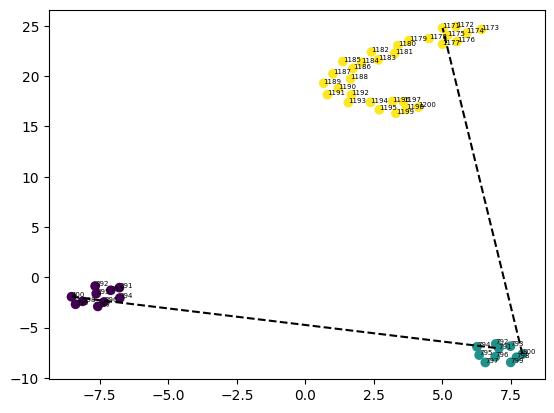

In [62]:
fig, ax = plt.subplots()
ax.scatter(u[:,0], u[:,1], c=colors_checkpoints_all)
for i, txt in enumerate(int_checkpoints_all):
    ax.annotate(str(txt), (u[i,0], u[i,1]), fontsize=5)
x_values = [u[a,0], u[b,0]]
y_values = [u[a,1], u[b,1]]
ax.plot(x_values, y_values, linestyle="--", c = 'black')
x_values2 = [u[c,0], u[d,0]]
y_values2 = [u[c,1], u[d,1]]
ax.plot(x_values2, y_values2, linestyle="--", c = 'black')
#plt.axis('off')
plt.savefig("plots/SGD_umap_{0}".format(datetime.now().strftime("%Y-%m-%d_%H%M%S")))
plt.show()

In [29]:
from sklearn.decomposition import PCA

In [36]:
import pandas as pd

In [39]:
pca = PCA(n_components=2)
pca_weights = pca.fit_transform(flat_weights.detach().numpy())

In [60]:
def plot_weights(u):
    fig, ax = plt.subplots()
    cmap = plt.cm.viridis
    ax.scatter(u[:,0], u[:,1], c=colors_checkpoints_all, alpha=0.1, cmap=cmap)
    #for i, txt in enumerate(int_checkpoints_all):
        #ax.annotate(str(txt), (u[i,0], u[i,1]), fontsize=5)
    x_values = [u[a,0], u[b,0]]
    y_values = [u[a,1], u[b,1]]
    #ax.plot(x_values, y_values, linestyle="--", c = 'black')
    x_values2 = [u[c,0], u[d,0]]
    y_values2 = [u[c,1], u[d,1]]
    #ax.plot(x_values2, y_values2, linestyle="--", c = 'black')
    #plt.axis('off')
    plt.savefig("plots/SGD_pca_{0}".format(datetime.now().strftime("%Y-%m-%d_%H%M%S")))
    plt.show()

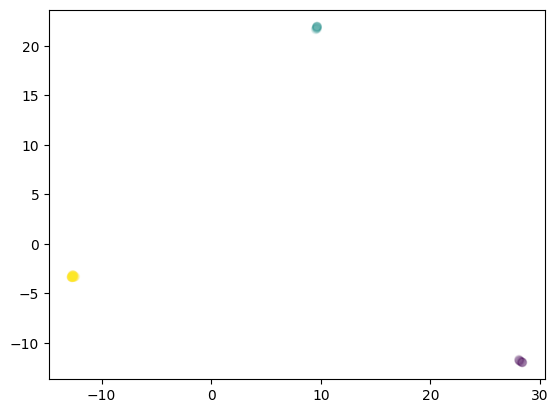

In [61]:
plot_weights(pca_weights)

In [98]:
from sklearn.manifold import TSNE


In [119]:
tsne = TSNE(perplexity = 6, init='random')
tsne_projections = tsne.fit_transform(flat_weights.detach().numpy())

/home/annalena/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


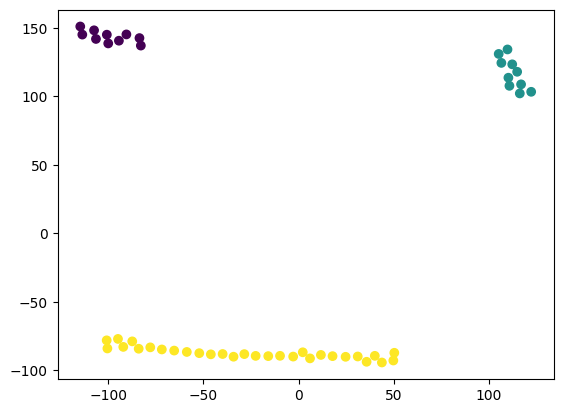

In [120]:
plt.scatter(tsne_projections[:,0], tsne_projections[:,1], c=colors_checkpoints_all)
plt.show()

# Adam

In [64]:
base = "/home/annalena/Seminar_Medical_Image_Analysis/code/"
input_folder = "/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_raw_data_base/nnUNet_raw_data/Task679_mnm/imagesTr/"
checkpoint_prediction_folder = "nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/prediction_Task679_mnm/"

model = base + "nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/"
folds = (0, ) # or None
save_npz = True

# default values - see documentation
num_parts = 1
part_id = 0 

# checkpoint list
max_cycles = 3
max_num_epochs = 120
max_num_epochs_per_cycle = int(max_num_epochs / max_cycles)
save_last_x_checkpoints_per_cycle = 10

checkpoints_multi_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(max_num_epochs) if max_num_epochs_per_cycle - (epoch % max_num_epochs_per_cycle) <= save_last_x_checkpoints_per_cycle]
checkpoints_single_modal = ["model_ep_%03.0d" % (epoch + 1) for epoch in range(max_num_epochs - save_last_x_checkpoints_per_cycle * max_cycles, max_num_epochs)]
checkpoints_all = list(set(checkpoints_multi_modal + checkpoints_single_modal))


In [65]:
pkl_file = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/"+checkpoints_multi_modal[0]+".model.pkl"
info = load_pickle(pkl_file)
init = info['init']
name = info['name']
print(init, name)

('/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_bs08_plans_2D.pkl', 0, '/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08', '/home/annalena/Seminar_Medical_Image_Analysis/code/data/nnUNet_preprocessed/Task500_ACDC', True, 0, True, False, False) nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta


In [66]:
# pkl file of the model
pkl = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/"+checkpoints_multi_modal[0]+".model.pkl"
checkpoint = pkl[:-4]
train = False

# find trainer class of one model.pkl and checkpoint
trainer = restore_model(pkl, checkpoint, train)
len_weights = 0
#t = torch.empty()

# get number of weights in the network
for param in trainer.network.parameters():
    len_weights += int(param.flatten().size(dim=0))
    #t.cat(param)
print(len_weights)

2023-03-09 10:17:37.838623: total nb epochs: 120 epoch per cycle:  40
2023-03-09 10:17:37.839229: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/model_ep_031.model train= False
29508192


In [68]:
# collect all weights of checkpoints in one tensor
flat_weights = torch.empty((len(checkpoints_all), len_weights ))
for i in range(len(checkpoints_all)):  
    pkl = "/home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/"+checkpoints_all[i]+".model.pkl"
    checkpoint = pkl[:-4]
    train = False
    trainer = restore_model(pkl, checkpoint, train)
    #t = torch.empty()
    helper = 0
    for param in trainer.network.parameters():
        l = int(param.flatten().size(dim=0))
        flat_weights[i, helper:helper+l] = param.flatten()
        helper += l
    print(helper - len_weights)

2023-03-09 10:19:01.627637: total nb epochs: 120 epoch per cycle:  40
2023-03-09 10:19:01.628242: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/model_ep_101.model train= False
0
2023-03-09 10:19:02.829850: total nb epochs: 120 epoch per cycle:  40
2023-03-09 10:19:02.830099: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/model_ep_113.model train= False
0
2023-03-09 10:19:03.969939: total nb epochs: 120 epoch per cycle:  40
2023-03-09 10:19:03.970185: loading checkpoint /home/annalena/Seminar_Medical_Image_Analysis/code/nnUNet_trained_models/nnUNet/2d/Task500_ACDC/nnUNetTrainerV2_Adam_fixedSchedule_Zhao2022_beta__nnUNetPlansv2.1_bs08/fold_0/model_ep_035.model train= False
0
2023-03-09 10:19:05.11184

In [69]:
int_checkpoints_all = [int(cp[-4:].replace('_', '')) for cp in checkpoints_all]
colors_checkpoints_all = []
for check in int_checkpoints_all:
    if check <= 40:
        colors_checkpoints_all.append(1)
    elif check <= 80:
        colors_checkpoints_all.append(2)
    elif check <= 120:
        colors_checkpoints_all.append(3)
np.unique(colors_checkpoints_all)

array([1, 2, 3])

In [80]:
fit = umap.UMAP(n_neighbors = 10, min_dist = 0.8)
u = fit.fit_transform(flat_weights.detach().numpy())

In [72]:
# which checkpoint id corresponds to the jumps
# jump from a to b and c to d
for i, check in enumerate(int_checkpoints_all):
    if check == 40:
        print("a", i, check)
        a = i
    if check == 80-9:
        print("b", i, check)
        b = i
    if check == 80:
        print("c", i, check)
        c = i
    if check == 120-29:
        print("d", i, check)
        d = i

d 8 91
b 17 71
c 22 80
a 44 40


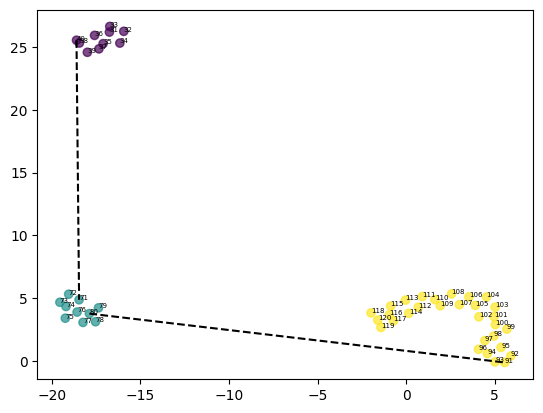

In [81]:
fig, ax = plt.subplots()
ax.scatter(u[:,0], u[:,1], c=colors_checkpoints_all, alpha=0.7)
for i, txt in enumerate(int_checkpoints_all):
    ax.annotate(str(txt), (u[i,0], u[i,1]), fontsize=5)
x_values = [u[a,0], u[b,0]]
y_values = [u[a,1], u[b,1]]
ax.plot(x_values, y_values, linestyle="--", c = 'black')
x_values2 = [u[c,0], u[d,0]]
y_values2 = [u[c,1], u[d,1]]
ax.plot(x_values2, y_values2, linestyle="--", c = 'black')
#plt.axis('off')
plt.savefig("plots/Adam_umap_{0}".format(datetime.now().strftime("%Y-%m-%d_%H%M%S")))
plt.show()

In [76]:
pca = PCA(n_components=2)
pca_weights = pca.fit_transform(flat_weights.detach().numpy())

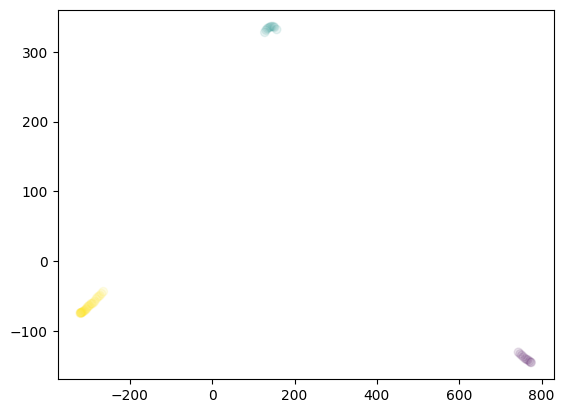

In [77]:
plot_weights(pca_weights)